In [14]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [15]:

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



    thresh = cm.numpy().max() / 1.5 if normalize else cm.numpy().max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("./deep_learning_plots/" + title + '.png')
    plt.show()
    

In [32]:
def plot_history(history, title1, title2):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("./deep_learning_plots/" + title1 + '.png')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("./deep_learning_plots/" + title2 + '.png')
    plt.show()

First, let us try to train on a simple dense model

In [20]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [ ]:
def create_model(shape):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=14))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    return model


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"


for ticker in tickers:
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1).to_numpy(), data['policy'].to_numpy()

    enc = OneHotEncoder(handle_unknown='ignore')
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
    enc_ytrain_labels = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
    enc_ytest_labels = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

    
    model = create_model(shape = X_train.shape)
    history = model.fit(X_train, enc_ytrain_labels, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, enc_ytest_labels))
    
    loss, accuracy, mse = model.evaluate(X_test, enc_ytest_labels, batch_size=16, verbose=1)
    
    y_pred = model.predict(X_test)
    print(y_pred)
    y_pred = np.argmax(y_pred, axis=1)
    print(f"Confusion Matrix for {ticker}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, np.arange(4), title=f"NN Confusion Matrix for {ticker} Dense")

    plot_history(history, f"NN Accuracy for {ticker} Dense", f"NN Loss for {ticker} Dense")
    print(classification_report(y_test, y_pred, zero_division=0))
    

Then let's try a more complex model

In [39]:
def lstm_data_transform(x_data, y_data, num_steps=28):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array
    
def create_model_LSTM(shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='tanh')))
    # model.add(Dropout(0.2))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    return model


Training for TSLA
Epoch 1/500
59/59 [==============================] - 10s 116ms/step - loss: 1.3406 - accuracy: 0.3627 - mse: 0.1815 - val_loss: 1.3550 - val_accuracy: 0.3561 - val_mse: 0.1836
Epoch 2/500
59/59 [==============================] - 5s 82ms/step - loss: 1.3112 - accuracy: 0.3893 - mse: 0.1776 - val_loss: 1.3362 - val_accuracy: 0.3945 - val_mse: 0.1811
Epoch 3/500
59/59 [==============================] - 5s 83ms/step - loss: 1.2923 - accuracy: 0.4005 - mse: 0.1750 - val_loss: 1.3218 - val_accuracy: 0.3817 - val_mse: 0.1789
Epoch 4/500
59/59 [==============================] - 5s 82ms/step - loss: 1.2665 - accuracy: 0.4187 - mse: 0.1712 - val_loss: 1.2829 - val_accuracy: 0.4030 - val_mse: 0.1732
Epoch 5/500
59/59 [==============================] - 5s 81ms/step - loss: 1.2349 - accuracy: 0.4192 - mse: 0.1666 - val_loss: 1.2519 - val_accuracy: 0.4414 - val_mse: 0.1684
Epoch 6/500
59/59 [==============================] - 5s 84ms/step - loss: 1.1963 - accuracy: 0.4400 - mse: 0.1

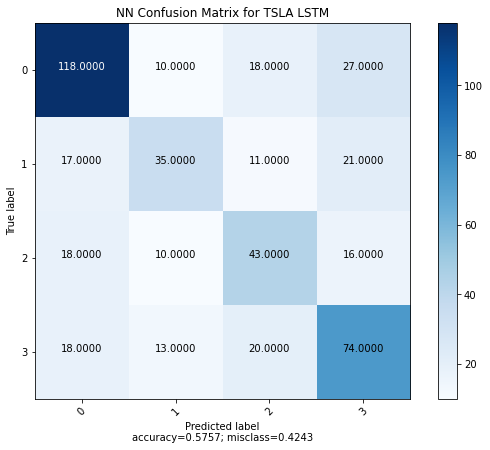

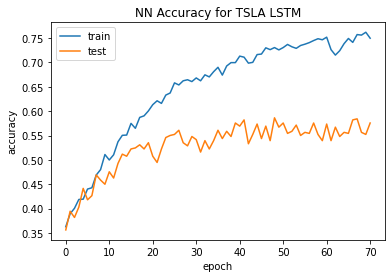

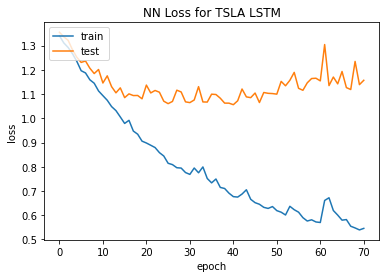

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69       173
         1.0       0.51      0.42      0.46        84
         2.0       0.47      0.49      0.48        87
         3.0       0.54      0.59      0.56       125

    accuracy                           0.58       469
   macro avg       0.55      0.55      0.55       469
weighted avg       0.58      0.58      0.57       469

Training for BABA
Epoch 1/500
41/41 [==============================] - 7s 108ms/step - loss: 1.3848 - accuracy: 0.3160 - mse: 0.1872 - val_loss: 1.3590 - val_accuracy: 0.3425 - val_mse: 0.1835
Epoch 2/500
41/41 [==============================] - 3s 68ms/step - loss: 1.3442 - accuracy: 0.3504 - mse: 0.1820 - val_loss: 1.3413 - val_accuracy: 0.3609 - val_mse: 0.1811
Epoch 3/500
41/41 [==============================] - 3s 67ms/step - loss: 1.3376 - accuracy: 0.3627 - mse: 0.1812 - val_loss: 1.3409 - val_accuracy: 0.3456 - val_mse: 0.1813
Epoch 4/500
41/41 [=====

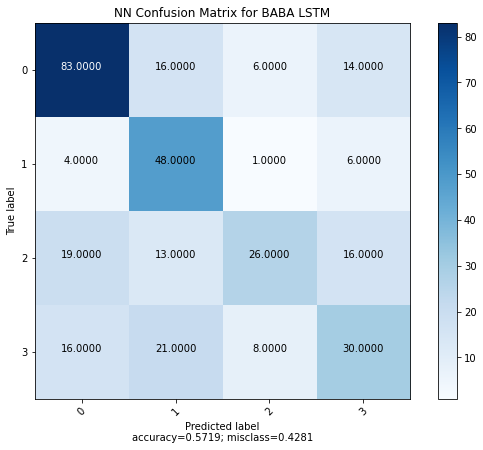

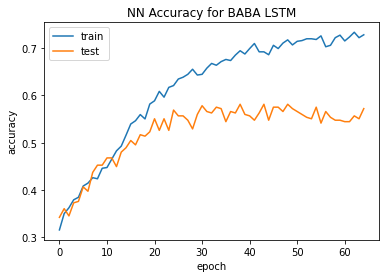

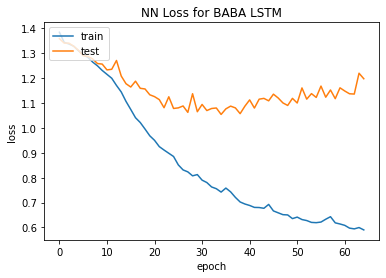

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       119
         1.0       0.49      0.81      0.61        59
         2.0       0.63      0.35      0.45        74
         3.0       0.45      0.40      0.43        75

    accuracy                           0.57       327
   macro avg       0.56      0.57      0.54       327
weighted avg       0.58      0.57      0.56       327

Training for HD
Epoch 1/500
59/59 [==============================] - 8s 94ms/step - loss: 1.3397 - accuracy: 0.3813 - mse: 0.1813 - val_loss: 1.3474 - val_accuracy: 0.3859 - val_mse: 0.1825
Epoch 2/500
59/59 [==============================] - 4s 69ms/step - loss: 1.3406 - accuracy: 0.3856 - mse: 0.1814 - val_loss: 1.3456 - val_accuracy: 0.3859 - val_mse: 0.1818
Epoch 3/500
59/59 [==============================] - 4s 67ms/step - loss: 1.3379 - accuracy: 0.3856 - mse: 0.1811 - val_loss: 1.3391 - val_accuracy: 0.3859 - val_mse: 0.1811
Epoch 4/500
59/59 [========

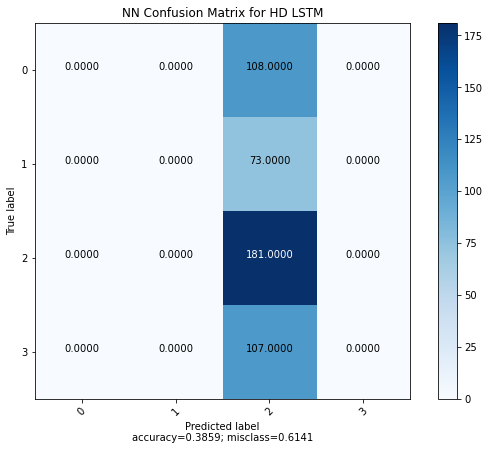

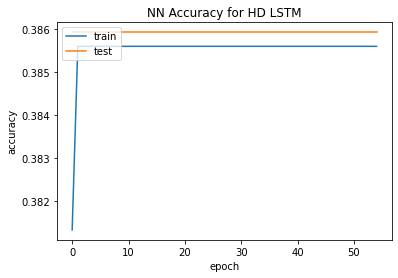

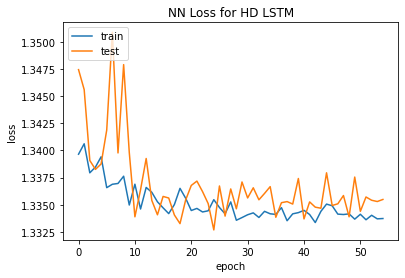

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       108
         1.0       0.00      0.00      0.00        73
         2.0       0.39      1.00      0.56       181
         3.0       0.00      0.00      0.00       107

    accuracy                           0.39       469
   macro avg       0.10      0.25      0.14       469
weighted avg       0.15      0.39      0.21       469

Training for TM
Epoch 1/500
59/59 [==============================] - 8s 98ms/step - loss: 1.3785 - accuracy: 0.2896 - mse: 0.1863 - val_loss: 1.3658 - val_accuracy: 0.2921 - val_mse: 0.1849
Epoch 2/500
59/59 [==============================] - 4s 69ms/step - loss: 1.3615 - accuracy: 0.3211 - mse: 0.1843 - val_loss: 1.3612 - val_accuracy: 0.3156 - val_mse: 0.1844
Epoch 3/500
59/59 [==============================] - 4s 68ms/step - loss: 1.3540 - accuracy: 0.3147 - mse: 0.1835 - val_loss: 1.3662 - val_accuracy: 0.3198 - val_mse: 0.1852
Epoch 4/500
59/59 [========

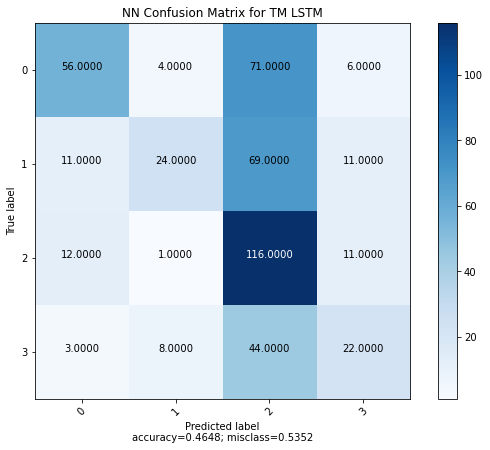

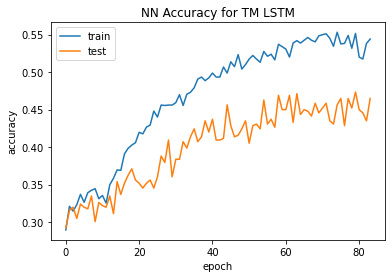

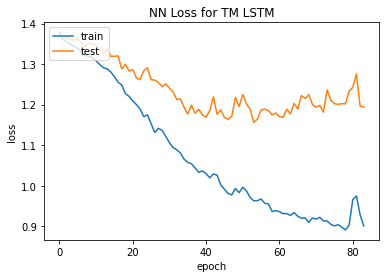

              precision    recall  f1-score   support

         0.0       0.68      0.41      0.51       137
         1.0       0.65      0.21      0.32       115
         2.0       0.39      0.83      0.53       140
         3.0       0.44      0.29      0.35        77

    accuracy                           0.46       469
   macro avg       0.54      0.43      0.43       469
weighted avg       0.55      0.46      0.44       469

Training for NKE
Epoch 1/500
59/59 [==============================] - 9s 109ms/step - loss: 1.3476 - accuracy: 0.3237 - mse: 0.1828 - val_loss: 1.3554 - val_accuracy: 0.3582 - val_mse: 0.1833
Epoch 2/500
59/59 [==============================] - 4s 70ms/step - loss: 1.3348 - accuracy: 0.3323 - mse: 0.1812 - val_loss: 1.3607 - val_accuracy: 0.3582 - val_mse: 0.1841
Epoch 3/500
59/59 [==============================] - 4s 71ms/step - loss: 1.3374 - accuracy: 0.3333 - mse: 0.1815 - val_loss: 1.3468 - val_accuracy: 0.3582 - val_mse: 0.1824
Epoch 4/500
59/59 [======

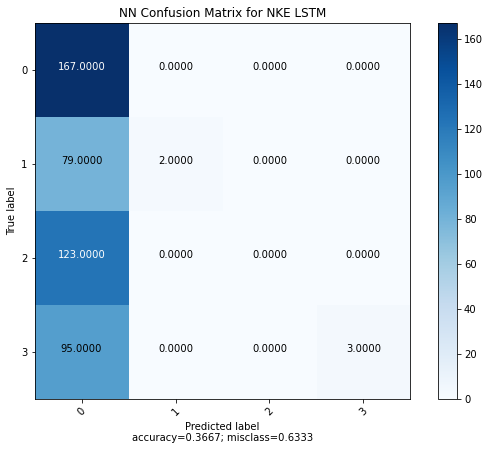

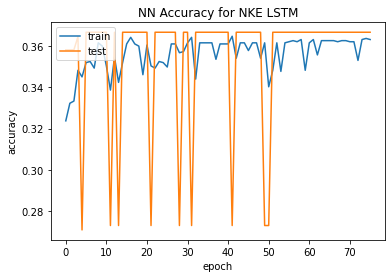

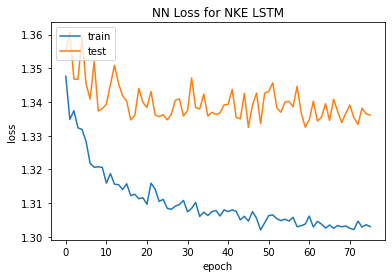

              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53       167
         1.0       1.00      0.02      0.05        81
         2.0       0.00      0.00      0.00       123
         3.0       1.00      0.03      0.06        98

    accuracy                           0.37       469
   macro avg       0.59      0.26      0.16       469
weighted avg       0.51      0.37      0.21       469

Training for MCD
Epoch 1/500
59/59 [==============================] - 9s 107ms/step - loss: 1.3961 - accuracy: 0.2608 - mse: 0.1886 - val_loss: 1.3910 - val_accuracy: 0.2473 - val_mse: 0.1881
Epoch 2/500
59/59 [==============================] - 4s 68ms/step - loss: 1.3885 - accuracy: 0.2683 - mse: 0.1878 - val_loss: 1.3885 - val_accuracy: 0.2473 - val_mse: 0.1878
Epoch 3/500
59/59 [==============================] - 4s 68ms/step - loss: 1.3863 - accuracy: 0.2757 - mse: 0.1875 - val_loss: 1.3923 - val_accuracy: 0.2473 - val_mse: 0.1881
Epoch 4/500
59/59 [======

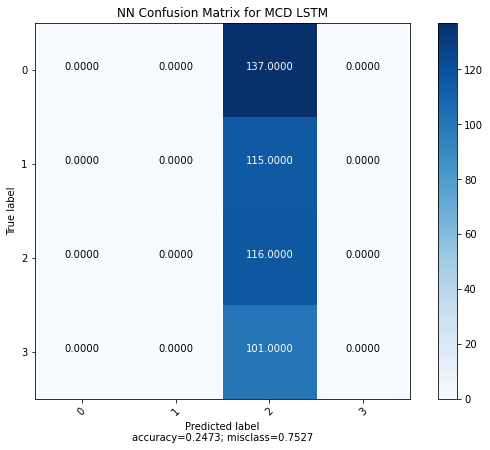

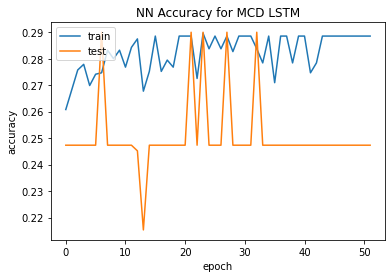

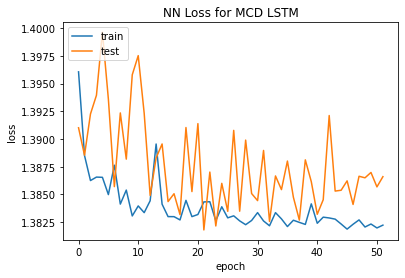

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       137
         1.0       0.00      0.00      0.00       115
         2.0       0.25      1.00      0.40       116
         3.0       0.00      0.00      0.00       101

    accuracy                           0.25       469
   macro avg       0.06      0.25      0.10       469
weighted avg       0.06      0.25      0.10       469

Training for LOW
Epoch 1/500
59/59 [==============================] - 9s 108ms/step - loss: 1.3575 - accuracy: 0.3157 - mse: 0.1839 - val_loss: 1.3411 - val_accuracy: 0.3390 - val_mse: 0.1819
Epoch 2/500
59/59 [==============================] - 4s 69ms/step - loss: 1.3500 - accuracy: 0.3349 - mse: 0.1830 - val_loss: 1.3273 - val_accuracy: 0.3390 - val_mse: 0.1802
Epoch 3/500
59/59 [==============================] - 4s 68ms/step - loss: 1.3511 - accuracy: 0.3237 - mse: 0.1832 - val_loss: 1.3233 - val_accuracy: 0.3390 - val_mse: 0.1798
Epoch 4/500
59/59 [======

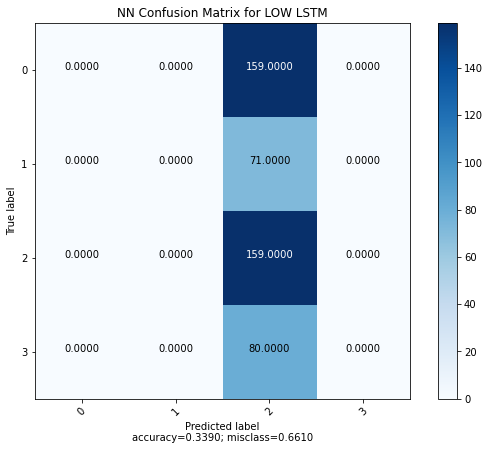

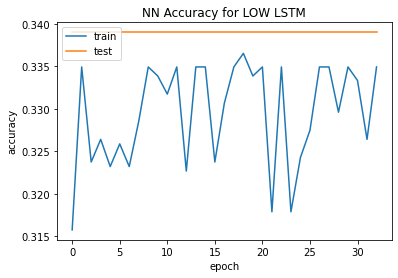

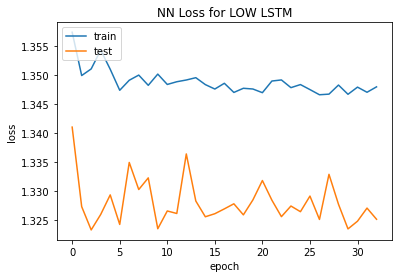

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       159
         1.0       0.00      0.00      0.00        71
         2.0       0.34      1.00      0.51       159
         3.0       0.00      0.00      0.00        80

    accuracy                           0.34       469
   macro avg       0.08      0.25      0.13       469
weighted avg       0.11      0.34      0.17       469

Training for SBUX
Epoch 1/500
59/59 [==============================] - 9s 107ms/step - loss: 1.3709 - accuracy: 0.3077 - mse: 0.1856 - val_loss: 1.3675 - val_accuracy: 0.2516 - val_mse: 0.1853
Epoch 2/500
59/59 [==============================] - 4s 70ms/step - loss: 1.3733 - accuracy: 0.3136 - mse: 0.1859 - val_loss: 1.3573 - val_accuracy: 0.3497 - val_mse: 0.1837
Epoch 3/500
59/59 [==============================] - 4s 70ms/step - loss: 1.3665 - accuracy: 0.3312 - mse: 0.1850 - val_loss: 1.3635 - val_accuracy: 0.3497 - val_mse: 0.1847
Epoch 4/500
59/59 [=====

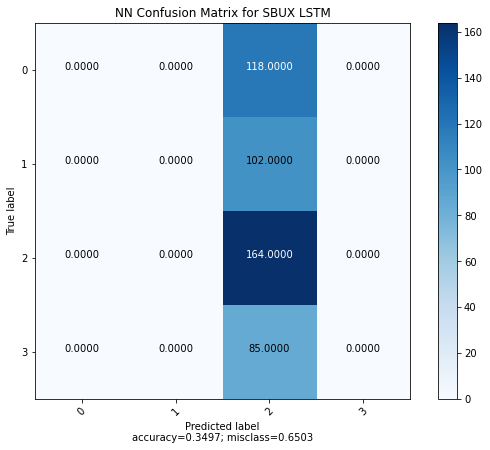

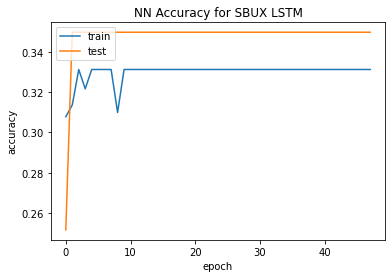

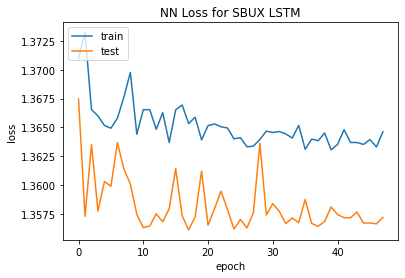

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       118
         1.0       0.00      0.00      0.00       102
         2.0       0.35      1.00      0.52       164
         3.0       0.00      0.00      0.00        85

    accuracy                           0.35       469
   macro avg       0.09      0.25      0.13       469
weighted avg       0.12      0.35      0.18       469

Training for JD
Epoch 1/500
43/43 [==============================] - 8s 121ms/step - loss: 1.3658 - accuracy: 0.3387 - mse: 0.1845 - val_loss: 1.3249 - val_accuracy: 0.3750 - val_mse: 0.1785
Epoch 2/500
43/43 [==============================] - 3s 72ms/step - loss: 1.3289 - accuracy: 0.3664 - mse: 0.1794 - val_loss: 1.3232 - val_accuracy: 0.3983 - val_mse: 0.1786
Epoch 3/500
43/43 [==============================] - 3s 68ms/step - loss: 1.3138 - accuracy: 0.3802 - mse: 0.1774 - val_loss: 1.3251 - val_accuracy: 0.3779 - val_mse: 0.1789
Epoch 4/500
43/43 [=======

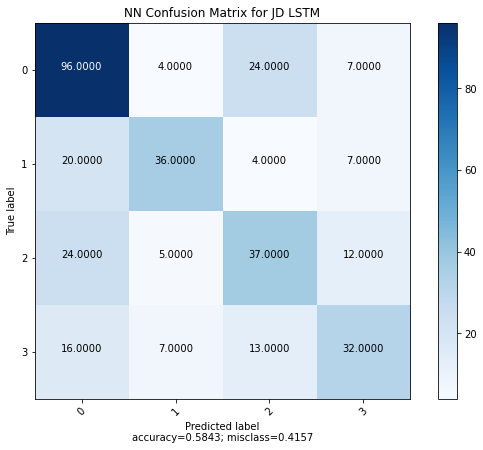

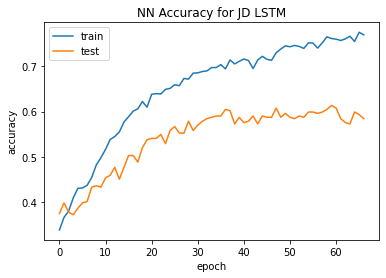

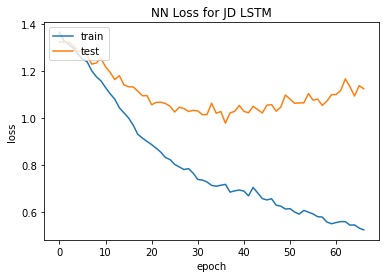

              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67       131
         1.0       0.69      0.54      0.61        67
         2.0       0.47      0.47      0.47        78
         3.0       0.55      0.47      0.51        68

    accuracy                           0.58       344
   macro avg       0.58      0.55      0.56       344
weighted avg       0.59      0.58      0.58       344



In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"



for ticker in tickers[1:10]:
    print("Training for " + ticker)
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1), data['policy']

    enc = OneHotEncoder(handle_unknown='ignore')

    features, labels = lstm_data_transform(features, labels)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
    enc_ytrain_labels = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
    enc_ytest_labels = enc.transform(y_test.reshape(-1, 1)).toarray()

    
    model = create_model_LSTM(shape = X_train.shape)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    history = model.fit(X_train, enc_ytrain_labels, epochs=500, batch_size=32, callbacks=[callback], verbose=1,  validation_data=(X_test, enc_ytest_labels))


    loss, accuracy, mse = model.evaluate(X_test, enc_ytest_labels, batch_size=16, verbose=1)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Confusion Matrix for {ticker}")
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, np.arange(4), title=f"NN Confusion Matrix for {ticker} LSTM")

    plot_history(history, f"NN Accuracy for {ticker} LSTM", f"NN Loss for {ticker} LSTM")
    print(classification_report(y_test, y_pred, zero_division=0))